In [11]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import os
import random
import numpy as np
import cv2
import random

import matplotlib.pyplot as plt

### VOC Dataset

In [5]:
VOC_COLORS = {
    'aeroplane': (255, 0, 0),
    'bicycle': (0, 255, 0),
    'bird': (0, 0, 255),
    'boat': (255, 255, 0),
    'bottle': (255, 0, 255),
    'bus': (0, 255, 255),
    'car': (128, 0, 0),
    'cat': (0, 128, 0),
    'chair': (0, 0, 128),
    'cow': (128, 128, 0),
    'diningtable': (128, 0, 128),
    'dog': (0, 128, 128),
    'horse': (128, 128, 128),
    'motorbike': (64, 0, 0),
    'person': (0, 64, 0),
    'pottedplant': (0, 0, 64),
    'sheep': (64, 64, 0),
    'sofa': (64, 0, 64),
    'train': (0, 64, 64),
    'tvmonitor': (64, 64, 64)
}

In [6]:
label2idx = {label: idx for idx, label in enumerate(VOC_COLORS.keys())}
idx2label = {idx: label for idx, label in enumerate(VOC_COLORS.keys())}

In [67]:
class VOCDataset(Dataset):
    def __init__(self, is_train, image_dir, label_txt, 
                 image_size = 448, grid_size = 7, num_bboxes = 2, num_classes = 20):
        self.is_train = is_train
        self.image_dir = image_dir
        self.label_txt = label_txt

        self.labels = []
        self.boxes = []
        self.paths = []
        
        with open(self.label_txt, 'r') as f:
            content = f.readlines()
            for label in content:
                total_label = label.strip().split()

                file_name = total_label[0]
                num_boxes = (len(total_label) - 1) // 5 
                box, label = [], []
                
                for i in range(num_boxes):
                    xmin = float(total_label[5 * i + 1])
                    ymin = float(total_label[5 * i + 2])
                    xmax = float(total_label[5 * i + 3])
                    ymax = float(total_label[5 * i + 4])
                    c = int(total_label[5 * i + 5])
            
                    box.append([xmin, ymin, xmax, ymax])
                    label.append(c)
                    
                box = torch.Tensor(box)
                label = torch.Tensor(label)
                self.boxes.append(box)
                self.labels.append(label)
                self.paths.append(os.path.join(image_dir, file_name))
                                  
        self.num_samples = len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = cv2.imread(path)
        boxes = self.boxes[idx]
        labels = self.labels[idx]

        if self.is_train:
            img, boxes = self.random_flip(img, boxes)
            img, boxes = self.random_scale(img, boxes)
            img, boxes = self.random_blur(img, boxes)

            img, boxes = self.random_brightness(img, boxes)
            img, boxes = self.random_hue(img, boxes)
            img, boxes = self.random_saturation(img, boxes)
                                           
            img, boxes, labels = self.random_shift(img, boxes, labels)
            img, boxes, labels = self.random_crop(img, boxes, labels)

        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        boxes /= torch.Tensor([[w, h, w, h]]).expand_as(boxes)

        
        return img, boxes, labels
    
    def random_flip(self, img, boxes):
        # if random.random() < 0.5:
        #     return img, boxes

        h, w, _ = img.shape
        img = cv2.flip(img, 1)

        x_min, x_max = boxes[:, 0], boxes[:, 2]
        xf_min, xf_max = w - x_max,  w - x_min
        boxes[:, 0], boxes[:, 2] = xf_min, xf_max

        return img, boxes

    def random_scale(self, img, boxes):
        # if random.random() < 0.5:
        #     return img, boxes

        h, w, _ = img.shape
        scale = random.uniform(0.8, 1.2)
        new_w = int(scale * w) 
        
        img = cv2.resize(img, (new_w, h),
                        interpolation=cv2.INTER_LINEAR)

        scale_indices = torch.Tensor([[scale, 1, scale, 1]]).expand_as(boxes)
        boxes = boxes * scale_indices

        return img, boxes

    def random_blur(self, img, boxes):
        # if random.random() < 0.5:
        #     return img, boxes

        h, w, _ = img.shape
        kernel = random.choice(range(3, 7, 2))

        img = cv2.blur(img, (kernel, kernel))
        return img, boxes
        
    def random_brightness(self, img, boxes):
        # if random.random() < 0.5:
        #     return img, boxes
            
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        adjust = random.uniform(0.5, 1.5)

        img_hsv[:, :, 2] = img_hsv[:, :, 2] * adjust
        img_hsv[:, :, 2]  = np.clip(img_hsv[:, :, 2], 0, 255).astype(img_hsv.dtype)
        img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

        return img, boxes

    def random_hue(self, img, boxes):
        # if random.random() < 0.5:
        #     return img, boxes
            
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        adjust = random.uniform(0.8, 1.2)

        img_hsv[:, :, 0] = img_hsv[:, :, 0] * adjust
        img_hsv[:, :, 0]  = np.clip(img_hsv[:, :, 0], 0, 255).astype(img_hsv.dtype)
        img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

        return img, boxes

    def random_saturation(self, img, boxes):
        # if random.random() < 0.5:
        #     return img, boxes
            
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        adjust = random.uniform(0.8, 1.2)

        img_hsv[:, :, 1] = img_hsv[:, :, 1] * adjust
        img_hsv[:, :, 1]  = np.clip(img_hsv[:, :, 1], 0, 255).astype(img_hsv.dtype)
        img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

        return img, boxes

    def random_shift(self, img, boxes, labels):
        # if random.random() < 0.5:
        #     return img, boxes

        h, w, c = img.shape
        img_out = np.zeros((h, w, c), dtype = img.dtype)
    
        center = (boxes[:, :2] + boxes[:, 2:]) // 2
        dx = int(random.uniform(-w * 0.2, w * 0.2))
        dy = int(random.uniform(-h * 0.2, w * 0.2))

        x_start = max(0, dx)
        x_end = min(w, w + dx)
        y_start = max(0, dy)
        y_end = min(h, h + dy)

        x_start_org = max(0, -dx)
        x_end_org = min(w, w - dx)
        y_start_org = max(0, -dy)
        y_end_org = min(h, h - dy)

        img_out[y_start:y_end, x_start:x_end, :] = img[y_start_org : y_end_org, x_start_org:x_end_org, :]

        boxes_shifted = boxes.clone()
        shifted_tensor = torch.Tensor([[dx, dy, dx, dy]]).expand_as(boxes_shifted)
        boxes_shifted = boxes_shifted + shifted_tensor
        
        shifted_center = center + torch.Tensor([[dx, dy]]).expand_as(center)
        masked_x = (shifted_center[:, 0] >= 0) & (shifted_center[:, 0] < w)
        masked_y = (shifted_center[:, 1] >= 0) & (shifted_center[:, 1] < h)
        mask = (masked_x & masked_y)
        
        boxes_shifted[:, 0] = boxes_shifted[:, 0].clamp_(min = 0, max = w)
        boxes_shifted[:, 2] = boxes_shifted[:, 2].clamp_(min = 0, max = w)
        boxes_shifted[:, 1] = boxes_shifted[:, 1].clamp_(min = 0, max = h)
        boxes_shifted[:, 3] = boxes_shifted[:, 3].clamp_(min = 0, max = h)

        labels_out = labels[mask]

        return img_out, boxes_shifted, labels_out

    def random_crop(self, img, boxes, labels):
        # if random.random() < 0.5:
        #     return img, boxes

        h_org, w_org, _ = img.shape
        center = (boxes[:, :2] + boxes[:, 2:]) // 2
        
        h = random.uniform(0.6 * h_org, h_org)
        w = random.uniform(0.6 * w_org, w_org)
        x = random.uniform(0, w_org - w)
        y = random.uniform(0, h_org - h)
        h, w, x, y = int(h), int(w), int(x), int(y)
        
        # print(f"Crop size y: {h}, x: {w}")
        img_crop = img[y: y + h, x: x + w, :]
        
        # Adjust the bounding boxes
        boxes_cropped = boxes.clone()
        boxes_cropped[:, [0, 2]] -= x
        boxes_cropped[:, [1, 3]] -= y
        
        cropped_center = center - torch.Tensor([[x, y]]).expand_as(center)
        masked_x = (cropped_center[:, 0] >= 0) & (cropped_center[:, 0] < w)
        masked_y = (cropped_center[:, 1] >= 0) & (cropped_center[:, 1] < h)
        mask = (masked_x & masked_y)
        
        # Clip the bounding boxes to be within the crop
        boxes_cropped[:, 0] = np.clip(boxes_cropped[:, 0], 0, w)
        boxes_cropped[:, 1] = np.clip(boxes_cropped[:, 1], 0, h)
        boxes_cropped[:, 2] = np.clip(boxes_cropped[:, 2], 0, w)
        boxes_cropped[:, 3] = np.clip(boxes_cropped[:, 3], 0, h)
        
        # Valid Boxes
        valid_boxes = (boxes_cropped[:, 2] > boxes_cropped[:, 0]) & \
                        (boxes_cropped[:, 3] > boxes_cropped[:, 1])
        boxes_cropped = boxes_cropped[valid_boxes]
        
        labels_out = labels[mask]

        return img_crop, boxes_cropped, labels_out

In [68]:
is_train = True
image_dir = 'VOC2012/VOCdevkit/VOC2012/JPEGImages/'
label_txt = 'voc2012.txt'

voc_dataset = VOCDataset(is_train, image_dir, label_txt)

img, boxes, labels = voc_dataset[0]

(417, 435, 3)


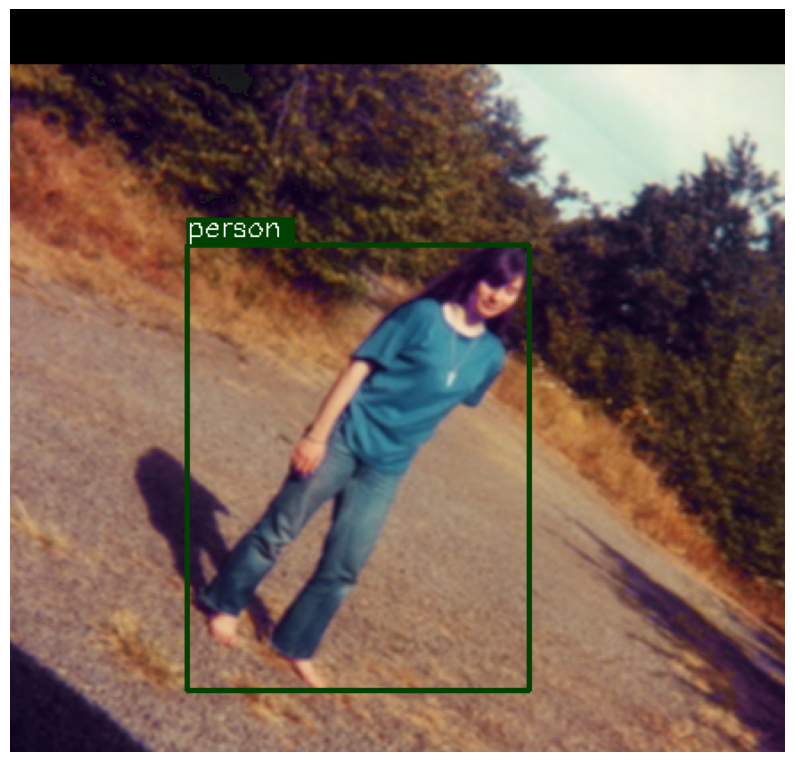

In [69]:
for b, c in zip(boxes, labels) :
    x_min, y_min, x_max, y_max = b
    x_min, y_min, x_max, y_max = int(x_min.item()), int(y_min.item()), int(x_max.item()), int(y_max.item())
    
    color = VOC_COLORS.get(idx2label[c.item()], (255, 255, 255))

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)

    # Draw the label
    text = f"{idx2label[c.item()]}"
    cv2.rectangle(img, (x_min, y_min - 15), (x_min + len(text) * 10, y_min), color, -1)
    cv2.putText(img, text, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

print(img.shape)
plt.figure(figsize = (10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()